#### **Processamento de Áudio e Imagem** (2º semestre de 2024)

### **Experiência: Estimação de partitura**


##### **Nome:** Ivan Matos

##### 7 de novembro de 2024

---
---

In [1]:
using DSP, FFTW, LaTeXStrings, MAT, WAV, PyPlot, Printf

In [2]:
mat = matread("sinal.mat")
x = mat["x"]
Ta = mat["Ta"]      # período de amostragem, em segundos

print("Ta = ", Ta)

Ta = 6.25e-5

In [3]:
fa = 1 / Ta         # frequência de amostragem, em Hz

print("fa = ", fa)

fa = 16000.0

Podemos reproduzir o sinal:

In [4]:
wavplay(x, fa)

O objetivo desta experiência consiste em identificar a nota mudical executada em cada trecho do sinal fornecido, por meio do uso da **Transformada de Fourier de Tempo Curto (*Short-Time Fourier Transform*, STFT)**. Determinaremos os valores dos parâmetros $M$, $R$ e $N$ (considerando a notação vista em aula) para o cálculo da STFT, além de experimentar diferentes tipos de janelas.

---

### **Determinação de $M$ e $R$**

Seja $M$ a largura da janela empregada no cálculo da STFT do sinal $x$, e seja $R$ o deslocamento de $x$ entre dois trechos consecutivos analisados. Como visto em aula, deve-se ter $R \leq M$.

Uma vez que conhecemos o instante de início da música, bem como a duração das notas, resulta que podemos analisar trechos bem definidos do sinal $x$. Portanto, podemos tomar $R=M$ (isto é, não haverá sobreposição entre intervalos consecutivos analisados). No sinal fornecido, as notas musicais são executadas individualmente, e cada trecho que analisaremos corresponde a uma única nota musical.

##### **Valor *máximo* de $M$:**

A taxa de amostragem do sinal é $T_a = 6,25 \cdot 10^{-5} \; \textrm{s}$, e o andamento da música é de **320 notas por minuto**. Desejamos que $M$ seja *no máximo* igual à (menor) duração de uma nota (em número de amostras). Logo:

$$M \leq \frac{\text{Duração de cada nota}}{T_a} = \frac{(60 \cdot 1/320) \; \text{s}}{6,25 \cdot 10^{-5} \; \text{s}} = 3000.$$


In [5]:
M_max = ceil(Int, (60/320) / Ta)

print("M_max = ", M_max)

In [6]:
# M = M_max

M_max = 3000

##### **Valor *mínimo* de $M$:**

A largura $M$ da janela utilizada no cálculo da STFT tem influência sobre a resolução na frequência. De fato, quanto menor é a janela, maior é a largura do lóbulo central de sua transformada (de forma aproximada, tal largura é inversamente proporcional à $M$); como resultado, maior é a dificuldade para "distinguir" entre frequências próximas, quando analisamos o espectro do sinal janelado. 

Em particular, para que sejamos capazes de distinguir entre as frequências fundamentais e suas respectivas 2ª harmônicas, devemos ter $M$ suficientemente grande. A menor diferença entre uma frequência fundamental e sua 2ª harmônica é verificada para a nota mais grave (sol2, em nosso caso). Para a frequência $f_0$ da nota mais grave, tem-se a seguinte diferença entre harmônicos sucessivos:

$$
2\cdot f_0 - f_0 = f_0 = (221 \, \textrm{Hz}) / \sqrt[^{6}]2 \approx 196,886 \; \textrm{Hz}.
$$

Em termos de frequência normalizada, tal diferença corresponde a 
$$
2 \pi \, 196,886 / f_a \approx 0,0773 \; \textrm{rad}.
$$

In [7]:
f0 = 221 / 2^(1/6)          # frequência da nota mais grave, em Hz
print("Freq. f0 da nota mais grave, em Hz: ", f0)

delta_omega = 2*pi*f0 / fa;

Freq. f0 da nota mais grave, em Hz: 196.88861670901497

A seguir, estimamos o valor "mínimo" de $M$, considerando a fórmula que aproxima a largura $\Delta\omega_\textrm{c}$ do lóbulo central da janela, para diferentes tipos de janela (retangular, Hamming, Blackman).

(Ver: Seção 7.5.1 de *Discrete-Time Signal Processing* — Oppenheim & Schafer, 2a ed.)

**Janela retangular:**

$\Delta\omega_\textrm{c} \approx \frac{4 \pi}{M + 1} \ll 0,0773 \; \textrm{rad} \iff M \gg 161,53$


**Janela de Hamming:**

$\Delta\omega_\textrm{c} \approx \frac{8 \pi}{M} \ll 0,0773 \; \textrm{rad} \iff M \gg 325,06$


**Janela de Blackman:**

$\Delta\omega_\textrm{c} \approx \frac{12 \pi}{M} \ll 0,0773 \; \textrm{rad} \iff M \gg 487,59$



In [8]:
print("Menor valor de M, considerando janela retangular:\n", 4*pi/delta_omega - 1)

Menor valor de M, considerando janela retangular:
161.52844138416262

In [9]:
print("Menor valor de M, considerando janela de Hamming:\n", 8*pi/delta_omega)

Menor valor de M, considerando janela de Hamming:
325.05688276832524

In [10]:
print("Menor valor de M, considerando janela de Blackman:\n", 12*pi/delta_omega)

Menor valor de M, considerando janela de Blackman:
487.58532415248783

---
### **Determinação de $N$**

Denotemos por $N$ o número de pontos utilizados para calcular a TDF, em cada intervalo. O valor de $N$ influencia o quão "fina" é a amostragem da STFT na frequência.
Logo, devemos escolher $N$ de forma que seja possível detectar apropriadamente a menor diferença de frequência possível entre notas, $\Delta f_{\textrm{min}}$.

Seja $f_0$ a frequência da nota mais grave (correspondente ao sol2, no nosso caso), e seja $f_1 = \sqrt[^{12}]2 \,\cdot\, f_0$ a frequência do semitom imediatamente acima. Então, a menor diferença de frequência entre notas é dada por

$$\Delta f_{\textrm{min}} = f_1 - f_0 = f_0 \cdot (\sqrt[^{12}]2 - 1),$$

onde $f_0 = (221 \; \textrm{Hz}) / \sqrt[^{6}]2 \approx 196,8886 \; \textrm{Hz}$.

Portanto,

$$\Delta f_{\textrm{min}} = (196,8886 \; \textrm{Hz}) \cdot (\sqrt[^{12}]2 - 1) \approx 11,7076 \; \textrm{Hz}.$$


In [11]:
f0 = 221 / 2^(1/6)                      # frequência da nota mais grave, em Hz
print("f0 = ", f0, "\n")

delta_f_min = f0 * ( 2^(1/12) - 1 )     # menor diferença de frequência entre duas notas, em Hz
print("delta_f_min = ", delta_f_min)

# w0 = 2*pi*f0 / fa

f0 = 196.88861670901497
delta_f_min = 11.707606393639285

A resolução do espectro na frequência é $f_a / N$. Se $N$ **não** for suficientemente grande, a identificação da frequência correspondente ao pico no espectro pode ocorrer com baixa precisão. Devemos ter, então:


$$\frac{f_a}{N} \ll \Delta f_{\textrm{min}}$$

$$\therefore \; \; N \gg \frac{f_a}{\Delta f_{\textrm{min}}} \approx 1366,63$$

In [12]:
print("fa / delta_f_min = ", fa / delta_f_min)

fa / delta_f_min = 1366.6328933549357

Ao calcular a TDF em cada intervalo (de comprimento $M$) do sinal $x$, será necessário completar o vetor de amostras com zeros se $M < N$.

---

### **Cálculo da *Transformada de Fourier de Tempo Curto* (STFT)**

A seguir, definimos uma função para calcular a STFT do sinal $x$, dados $M$, $R$, $N$ e o tipo de janela desejado. A função retorna: 
- uma matriz `X` em que cada coluna corresponde à TDF calculada para um trecho do sinal $x$;
- um vetor `freqs_picos` que contém, para cada trecho analisado de $x$, uma estimativa da frequência correspondente ao maior pico (em módulo) da TDF calculada para tal trecho;
- um vetor `energia_por_trecho`, que contém o valor da energia média calculada para cada um dos trechos do sinal $x$.

*Observação*: o cálculo de energia média é útil para que possamos determinar quais trechos do sinal correspondem a "silêncio" (isto é, a uma pausa, ausência de música).

In [13]:
"""
Calcula a STFT de um sinal x.
Retorna:

    - Uma matriz `X`, cuja i-ésima coluna corresponde à TDF calculada para um trecho
      (de tamanho M) do sinal x, sendo este último deslocado de n=i*`R` amostras;

    - Um vetor `freqs_picos`, cuja i-ésima posição é a frequência associada ao maior
      pico do espectro calculado para o i-ésimo trecho do sinal x;

    - Um vetor `energia_por_trecho`, cuja i-ésima coluna corresponde à energia média calculada
      para o i-ésimo intervalo do sinal x. 
"""
function calcula_stft(x, M, R, N; tipo_janela="rectangular",  w = nothing)

    # tipo_janela: `rectangular`, `hamming`, `blackwell`

    # OBSERVAÇÃO: `w` deve ser uma janela de comprimento M ou `nothing`.

    if w == nothing
        
        if tipo_janela == "rectangular"
            w = ones(M)                     # w = rect(M)
        elseif tipo_janela == "hamming"
            w = hamming(M)
        elseif tipo_janela == "blackman"
            w = blackman(M)
        end 

    end

    X = zeros(Complex, N, ceil(Int,length(x)/R))

    freqs_picos = []          # Vetor para armazenar a frequência correspondente ao pico da TDF em cada trecho do sinal

    energia_por_trecho = []   # Vetor para armazenar a energia média em cada trecho do sinal

    for i in 0:(ceil(Int, length(x)/R)-1)

        n = i * R
        
        # Trecho de tamanho M do sinal x, deslocado de n amostras
        trecho_x = x[n+1 : min(n + M, length(x))]

        # Aplicação da janela desejada ao trecho do sinal
        trecho_x_janelado = trecho_x .* w[1:length(trecho_x)]

        # Trecho completado com zeros, a fim de permitir o cálculo da TDF com N pontos
        trecho_completado_com_zeros = [trecho_x_janelado; zeros(N - length(trecho_x_janelado))]

        # Cálculo da TDF (com N pontos) para o i-ésimo trecho do sinal
        X_n = fft(trecho_completado_com_zeros)
        X[:,i+1] = X_n

        # Frequência correspondente ao pico no espectro do i-ésimo trecho do sinal
        freq_pico = (argmax(abs.(X_n[1:ceil(Int,N/2)])) - 1) * fa / N
        push!(freqs_picos, freq_pico)

        # Energia média, calculada para o i-ésimo trecho do sinal
        energia_media = sum(trecho_x.^2) / length(trecho_x)
        push!(energia_por_trecho, energia_media)

    end

    return X, freqs_picos, energia_por_trecho

end

calcula_stft

In [14]:
# plot(abs.(fft([x[200*M:201*M-1]; zeros(N-M)]))[1:125], marker=(:circle, 3), line = :stem, title = "Janela Retangular")

### **Espectrograma do sinal**

Para plotar o espectrograma do sinal, utilizamos a função ``plota_stft``, fornecida na página da disciplina:

In [15]:
# FUNÇÃO FORNECIDA NA PÁGINA DA DISCIPLINA

function plota_stft(X, M, R, fa; scale = "linear")
    N,Np = size(X) # N = número de pontos da FFT
    Nyticks = 8 # número de marcações na vertical
    ytickpos = (0:(N-1)/Nyticks:N-1) # posições das marcações na vertical
    yticklabels = (fa/2)*ytickpos/(N-1)
    Nxticks = 8
    xtickpos = 1:Np÷Nxticks:Np
    xticklabels =  round.((xtickpos .- 1) * R/fa .+ (M-1)/(2fa), digits=2)
    # xticklabels =  xtickpos .- 1
    if scale == "linear"
        ppow = abs.(X)
    else
        ppow = pow2db.(abs.(X))
    end
    ax=pcolormesh(ppow);
    yticks(round.(Int,ytickpos), yticklabels);
    xticks(xtickpos, xticklabels);
    xlabel(L"$t$  (s)");
    ylabel(L"$f$  (Hz)");
    return ax
end

plota_stft (generic function with 1 method)

### **Estimação da partitura**

Definimos, abaixo, uma função que estima a nota musical associada a uma dada frequência.


Consideramos uma tabela que relaciona algumas notas musicais a suas respectivas frequências (dicionário `tabela_notas_freqs`, abaixo). Para cada trecho do sinal, a ideia consiste em buscar, na tabela mencionada, qual é o valor de frequência mais próximo da frequência estimada no trecho considerado (e, portanto, qual é a nota musical correspondente). 

In [16]:
# Tabela frequências (em Hz) vs. notas
tabela_notas_freqs = Dict([
    (196.889,  "sol2"),
    (208.596,  "sol#2"),
    (221,      "lá2"),
    (234.141,  "lá#2"),
    (248.064,  "si2"),

    (262.815,  "dó3"),
    (278.443,  "dó#3"),
    (295,      "ré3"),
    (312.541,  "ré#3"),
    (331.126,  "mi3"),
    (350.816,  "fá3"),
    (371.676,  "fá#3"),
    (393.777,  "sol3"),
    (417.192,  "sol#3"),
    (442,      "lá3"),
    (468.283,  "lá#3"),
    (496.128,  "si3"),

    (525.63,   "dó4"),
    (556.885,  "dó#4"),	
    (589.999,  "ré4"),
    (625.082,  "ré#4"),
    (662.252,  "mi4"),
    (701.631,  "fá4"),
    (743.352,  "fá#4"),
    (787.554,  "sol4"),
    (834.385,  "sol#4"),
    (884,      "lá4"),
    (936.565,  "lá#4"),
    (992.256,  "si4"),

    (1051.259, "dó5"),
    (1113.77,  "dó#5"),
    (1179.998, "ré5"),
    (1250.165, "ré#5"),
    (1324.503, "mi5"),
    (1403.263, "fá5"),
    (1486.705, "fá#5"),
    (1575.109, "sol5"),
    (1668.77,  "sol#5"),
    (1768,     "lá5"),
    (1873.131, "lá#5"),
    (1984.513, "si5")
])



function estima_nota(freq)

    freqs = collect(keys(tabela_notas_freqs))

    dists = abs.(freqs .- freq)     # distâncias entre a frequência estimada e as diferentes frequências da tabela

    idx = argmin(dists)

    freq_mais_proxima = freqs[idx]

    nota = tabela_notas_freqs[freq_mais_proxima]

    return nota

end

estima_nota (generic function with 1 method)

Abaixo, escolhemos os parâmetros $M$, $R$ e $N$, com base nas restrições obtidas, e lembrando que $R \leq M \leq N$:

In [17]:
M = 3000
R = M
N = 4096;    # potência de 2

Escolhemos $M = R = 3000$, uma vez que a duração de cada nota corresponde a $3000$ amostras, conforme calculado anteriormente. Por outro lado, tomamos $N = 4096$, pois, como determinado, devemos ter $N$ suficientemente maior do que $1367$.


A seguir, apresentamos o espectrograma do sinal e a sequência de notas musicais estimada, considerando o uso de diferentes janelas no cálculo da STFT. Em particular, testamos o emprego das janelas *retangular*, de *Hamming*, e de *Blackman*.

**Observação**: Para identificar se um trecho do sinal corresponde a "silêncio" (neste caso, ausência de música), verificamos a energia média do trecho considerado, e comparamos com um valor de "limiar". Se a energia média for inferior a tal limiar, então assumiremos que o trecho corresponde a uma pausa ("silêncio"). Para determinar o valor do limiar, podemos calcular a energia média de um trecho que já sabemos tratar-se de uma pausa (em nosso caso, podemos considerar as primeiras 3000 amostras, por exemplo):

In [18]:
print("Energia média de um trecho de silêncio: ", sum(x[:3000].^2) / 3000)

Energia média de um trecho de silêncio: 0.0

Observamos que, neste caso, a energia média da "pausa" é igual a *zero*. Isso ocorre pois o sinal foi (artificialmente) gerado de forma que, enquanto nenhuma nota é executada, as amostras são nulas. Na prática, em uma situação real, a energia média de um trecho de silêncio não é necessariamente nula, e mais experimentos podem ser necessários a fim de determinar empiricamente um limiar adequado para a detecção de pausas.

#### **Usando janela retangular**

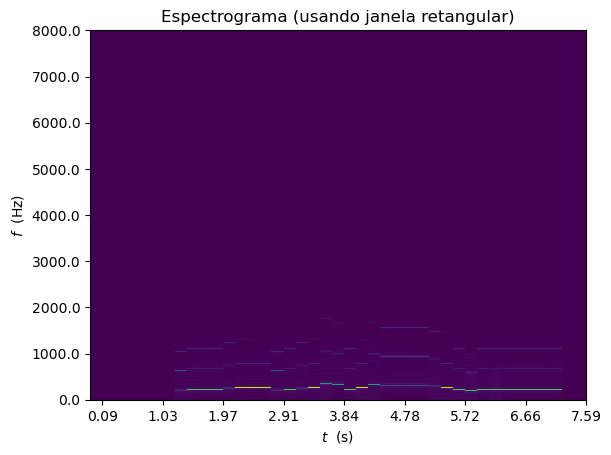

In [19]:
X, freqs_picos, energia_por_trecho = calcula_stft(x, M, R, N, tipo_janela="rectangular")

plota_stft(X[1:floor(Int, N/2),:], M, R, fa, scale="linear")
title("Espectrograma (usando janela retangular)")
PyPlot.display_figs()

Apresentamos a frequência estimada e nota musical correspondente, para *cada* trecho de tamanho $M$ do sinal.

In [20]:
print("Frequência estimada e nota correspondente, para cada trecho de tamanho M:\n\n")

print("Freq. identificada (Hz) ---> Nota correspondente:\n\n")

# notas_estimadas = []

for (freq, energia) in zip(freqs_picos, energia_por_trecho)

    if energia < 1e-3
        print("(Trecho de silêncio) \n")

    elseif freq != 0

        nota_estimada = estima_nota(freq)
        @printf("%.2f  --->  ", freq)
        print(nota_estimada, "\n")
        
        # if (length(notas_estimadas) == 0) || (nota_estimada != notas_estimadas[end])
        #     push!(notas_estimadas, nota_estimada)
        # end

    end
end

Frequência estimada e nota correspondente, para cada trecho de tamanho M:

Freq. identificada (Hz) ---> Nota correspondente:

(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
207.03  --->  sol#2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
246.09  --->  si2
261.72  --->  dó3
261.72  --->  dó3
261.72  --->  dó3
207.03  --->  sol#2
222.66  --->  lá2
250.00  --->  si2
261.72  --->  dó3
351.56  --->  fá3
332.03  --->  mi3
222.66  --->  lá2
261.72  --->  dó3
332.03  --->  mi3
312.50  --->  ré#3
312.50  --->  ré#3
312.50  --->  ré#3
312.50  --->  ré#3
296.88  --->  ré3
261.72  --->  dó3
222.66  --->  lá2
195.31  --->  sol2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
(Trecho de silêncio) 
(Trecho de silêncio) 


In [21]:
# plot(freqs_picos)
# PyPlot.display_figs()

#### **Usando janela de Hamming**

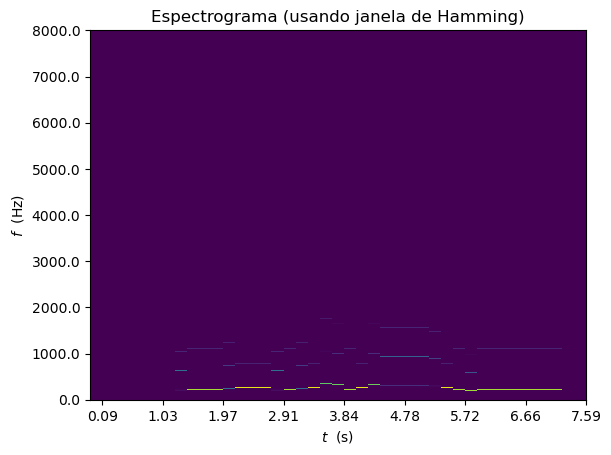

In [22]:
X, freqs_picos = calcula_stft(x, M, R, N, tipo_janela="hamming")

plota_stft(X[1:floor(Int, N/2),:], M, R, fa, scale="linear")
title("Espectrograma (usando janela de Hamming)")
PyPlot.display_figs()

In [23]:
print("Frequência estimada e nota correspondente, para cada trecho de tamanho M:\n\n")

print("Freq. identificada (Hz) ---> Nota correspondente:\n\n")

# notas_estimadas = []

for (freq, energia) in zip(freqs_picos, energia_por_trecho)

    if energia < 1e-3
        print("(Trecho de silêncio) \n")

    elseif freq != 0

        nota_estimada = estima_nota(freq)
        @printf("%.2f  --->  ", freq)
        print(nota_estimada, "\n")
        
        # if (length(notas_estimadas) == 0) || (nota_estimada != notas_estimadas[end])
        #     push!(notas_estimadas, nota_estimada)
        # end

    end
end

Frequência estimada e nota correspondente, para cada trecho de tamanho M:

Freq. identificada (Hz) ---> Nota correspondente:

(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
207.03  --->  sol#2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
250.00  --->  si2
261.72  --->  dó3
261.72  --->  dó3
261.72  --->  dó3
207.03  --->  sol#2
222.66  --->  lá2
250.00  --->  si2
261.72  --->  dó3
351.56  --->  fá3
332.03  --->  mi3
222.66  --->  lá2
261.72  --->  dó3
332.03  --->  mi3
312.50  --->  ré#3
312.50  --->  ré#3
312.50  --->  ré#3
312.50  --->  ré#3
296.88  --->  ré3
261.72  --->  dó3
222.66  --->  lá2
195.31  --->  sol2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
(Trecho de silêncio) 
(Trecho de silêncio) 


#### **Usando janela de Blackman**

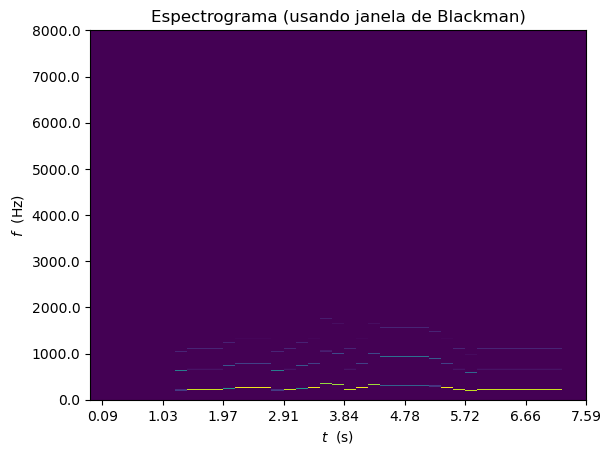

In [24]:
X, freqs_picos = calcula_stft(x, M, R, N, tipo_janela="blackman")

plota_stft(X[1:floor(Int, N/2),:], M, R, fa, scale="linear")
title("Espectrograma (usando janela de Blackman)")
PyPlot.display_figs()

In [25]:
print("Frequência estimada e nota correspondente, para cada trecho de tamanho M:\n\n")

print("Freq. identificada (Hz) ---> Nota correspondente:\n\n")

# notas_estimadas = []

for (freq, energia) in zip(freqs_picos, energia_por_trecho)

    if energia < 1e-3
        print("(Trecho de silêncio) \n")

    elseif freq != 0

        nota_estimada = estima_nota(freq)
        @printf("%.2f  --->  ", freq)
        print(nota_estimada, "\n")
        
        # if (length(notas_estimadas) == 0) || (nota_estimada != notas_estimadas[end])
        #     push!(notas_estimadas, nota_estimada)
        # end

    end
end

Frequência estimada e nota correspondente, para cada trecho de tamanho M:

Freq. identificada (Hz) ---> Nota correspondente:

(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
(Trecho de silêncio) 
207.03  --->  sol#2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
250.00  --->  si2
261.72  --->  dó3
261.72  --->  dó3
261.72  --->  dó3
207.03  --->  sol#2
222.66  --->  lá2
250.00  --->  si2
261.72  --->  dó3
351.56  --->  fá3
332.03  --->  mi3
222.66  --->  lá2
261.72  --->  dó3
332.03  --->  mi3
312.50  --->  ré#3
312.50  --->  ré#3
312.50  --->  ré#3
312.50  --->  ré#3
296.88  --->  ré3
261.72  --->  dó3
222.66  --->  lá2
195.31  --->  sol2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
222.66  --->  lá2
(Trecho de silêncio) 
(Trecho de silêncio) 


In [26]:
# plot((0:length(X[:,24])-1)*fa/N, abs.(X[:,24]))
# PyPlot.display_figs()

# plot(freqs_picos)
# PyPlot.display_figs()

Observamos que os resultados obtidos usando as diferentes janelas (retangular, Hamming, Blackman) são compatíveis entre si. De fato, no caso considerado, poderíamos (a princípio) optar por qualquer uma das janelas mencionadas, desde que respeitemos as restrições envolvendo o valor de $M$.